In [1]:
import torch
from torch.utils.data import DataLoader
from collections import OrderedDict

from tqdm import tqdm
from torchvision.transforms import transforms as T
import torch.nn.functional as F

from utils.factory import model_factory, dataset_factory
from utils.data_format import print_metric
# from utils.onehot_convert import *
from utils.metrics import *

import matplotlib.pyplot as plt

In [2]:
def get_model(model_path, model_name, class_num:int=1):
    model = model_factory(model_name)(1, class_num)
    state_dict = torch.load(model_path)
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if k.startswith('module.'):
            name = k[7:] # remove `module.`
            new_state_dict[name] = v
        else:
            new_state_dict[k] = v
    model.load_state_dict(new_state_dict)
    model.to(torch.device('cuda:0'))
    return model

In [3]:
def test_paper_single(model, test_data_path, device=torch.device('cpu'), dataset_class:str="Covid19PaperTestDataset", class_num:int=1, idx=0):
    if class_num <= 2:
        metric_list = list(BINARY_METRIC_MAP.keys())
    else:
        metric_list = list(CONFUSION_MATRIX_METRIC_MAP.keys())
    image_transform = T.Compose([
    #     T.Resize((224, 224)),
        T.ToTensor(),
    ])

    mask_transform = T.Compose([
    #     T.Resize((224, 224), Image.NEAREST),
        T.ToTensor(),
    ])
    dataset_cls = dataset_factory(dataset_class)
    
    test_data = dataset_cls(test_data_path, image_transform, mask_transform, is_file=True)
    
    model.eval()
    with torch.no_grad():
        x, y, org_x, org_y, location = test_data[idx]
        x = x.unsqueeze(0)
        y = y.unsqueeze(0)
        org_x = org_x.unsqueeze(0)
        org_y = org_y.unsqueeze(0)
        image = x.to(device)
        true_mask = org_y.to(device)
        plt.imshow(org_x[0, 0, :, :].cpu().numpy(), cmap="gray")
        plt.show()
        plt.imshow(org_y[0, 0, :, :].cpu().numpy(), cmap="gray")
        plt.show()

        pred_mask = model(image)
        plt.imshow(pred_mask[0, 0, :, :].cpu().numpy(), cmap="gray")
        plt.show()
        pred_mask = F.interpolate(pred_mask, size=(location[1]-location[0]+1, location[3]-location[2]+1), mode='bilinear', align_corners=False)
        #             print(pred_mask.size())
        plt.imshow(x[0, 0, :, :].numpy(), cmap="gray")
        plt.show()
        plt.imshow(y[0, 0, :, :].numpy(), cmap="gray")
        plt.show()
        plt.imshow(pred_mask[0, 0, :, :].cpu().numpy(), cmap="gray")
        plt.show()
        


        if class_num > 2:
            pred_mask = torch.softmax(pred_mask, dim=1)
        else:
            pred_mask = torch.sigmoid(pred_mask)
        # break
        plt.imshow(pred_mask[0, 0, :, :].cpu().numpy(), cmap="gray")
        plt.show()
        if class_num > 2:
            pred_mask = torch.argmax(pred_mask, dim=1, keepdim=True)
            true_mask = torch.argmax(true_mask, dim=1, keepdim=True)
            org_pred = torch.zeros(tuple(true_mask.size())).to(device)
            org_pred[:, :, location[0]:location[1]+1, location[2]: location[3]+1] = pred_mask
            batch_metric = cal_metric_by_cm(
                true_mask, pred_mask, class_num=class_num, metric_list=metric_list, rm_bg=True)
        else:
            pred_mask = torch.where(pred_mask >= 0.5, torch.ones_like(
                pred_mask), torch.zeros_like(pred_mask))
            plt.imshow(pred_mask[0, 0, :, :].cpu().numpy(), cmap="gray")
            plt.show()
            org_pred = torch.zeros(tuple(org_y.size())).to(device)
            org_pred[:, :, location[0]:location[1]+1, location[2]: location[3]+1] = pred_mask
            plt.imshow(org_pred[0, 0, :, :].cpu().numpy(), cmap="gray")
            plt.show()
            batch_metric = cal_binary_metric(
                true_mask, org_pred, metric_list=metric_list)
        print(print_metric(batch_metric))

In [4]:
def test_paper(model, test_data_path, device=torch.device('cpu'), dataset_class:str="Covid19PaperTestDataset", class_num:int=1):
    if class_num <= 2:
        metric_list = list(BINARY_METRIC_MAP.keys())
    else:
        metric_list = list(CONFUSION_MATRIX_METRIC_MAP.keys())
    image_transform = T.Compose([
    #     T.Resize((224, 224)),
        T.ToTensor(),
    ])

    mask_transform = T.Compose([
    #     T.Resize((224, 224), Image.NEAREST),
        T.ToTensor(),
    ])
    dataset_cls = dataset_factory(dataset_class)
    
    test_data = dataset_cls(test_data_path, image_transform, mask_transform, is_file=True)
    
    model.eval()
    with torch.no_grad():
        epoch_metric = AvgMetricPool()
        data_list = []
        for i in tqdm(range(len(test_data))):
            x, y, org_x, org_y, location = test_data[i]
            x = x.unsqueeze(0)
            y = y.unsqueeze(0)
            org_x = org_x.unsqueeze(0)
            org_y = org_y.unsqueeze(0)
            image = x.to(device)
            true_mask = org_y.to(device)
#             plt.imshow(org_y[0, 0, :, :].cpu().numpy(), cmap="gray")
#             plt.show()
            
            pred_mask = model(image)
            
            pred_mask = F.interpolate(pred_mask, size=(location[1]-location[0]+1, location[3]-location[2]+1), mode='bilinear', align_corners=False)
            #             print(pred_mask.size())
            
            
            if class_num > 2:
                pred_mask = torch.softmax(pred_mask, dim=1)
            else:
                pred_mask = torch.sigmoid(pred_mask)
            # break
            
            if class_num > 2:
                pred_mask = torch.argmax(pred_mask, dim=1, keepdim=True)
                true_mask = torch.argmax(true_mask, dim=1, keepdim=True)
                org_pred = torch.zeros(tuple(true_mask.size())).to(device)
                org_pred[:, :, location[0]:location[1]+1, location[2]: location[3]+1] = pred_mask
                batch_metric = cal_metric_by_cm(
                    true_mask, pred_mask, class_num=class_num, metric_list=metric_list, rm_bg=True)
            else:
                pred_mask = torch.where(pred_mask >= 0.5, torch.ones_like(
                    pred_mask), torch.zeros_like(pred_mask))
                org_pred = torch.zeros(tuple(org_y.size())).to(device)
                org_pred[:, :, location[0]:location[1]+1, location[2]: location[3]+1] = pred_mask
                batch_metric = cal_binary_metric(
                    true_mask, org_pred, metric_list=metric_list)
            epoch_metric.add_batch(batch_metric)
            data_list.append(print_metric(batch_metric)+"\n")
            torch.cuda.empty_cache()
            del x, y, image, true_mask, pred_mask
        with open("../result_dealed.txt", "w", encoding="utf-8") as f:
            f.write("".join(data_list))
        return epoch_metric.avg_metric

In [5]:
def test_paper_org_single(model, test_data_path, device=torch.device('cpu'), dataset_class:str="Covid19PaperOrgTestDataset", class_num:int=1, idx=0):
    if class_num <= 2:
        metric_list = list(BINARY_METRIC_MAP.keys())
    else:
        metric_list = list(CONFUSION_MATRIX_METRIC_MAP.keys())
    image_transform = T.Compose([
    #     T.Resize((224, 224)),
        T.ToTensor(),
    ])

    mask_transform = T.Compose([
    #     T.Resize((224, 224), Image.NEAREST),
        T.ToTensor(),
    ])
    dataset_cls = dataset_factory(dataset_class)
    
    test_data = dataset_cls(test_data_path, image_transform, mask_transform, is_file=True)
    
    model.eval()
    with torch.no_grad():
        x, y, org_x, org_y = test_data[idx]
        x = x.unsqueeze(0)
        y = y.unsqueeze(0)
        org_x = org_x.unsqueeze(0)
        org_y = org_y.unsqueeze(0)
        image = x.to(device)
        true_mask = org_y.to(device)
        plt.imshow(org_x[0, 0, :, :].cpu().numpy(), cmap="gray")
        plt.show()
        plt.imshow(org_y[0, 0, :, :].cpu().numpy(), cmap="gray")
        plt.show()

        pred_mask = model(image)

        pred_mask = F.interpolate(pred_mask, size=(true_mask.size()[2], true_mask.size()[3]), mode='bilinear', align_corners=False)
        plt.imshow(x[0, 0, :, :].numpy(), cmap="gray")
        plt.show()
        plt.imshow(y[0, 0, :, :].numpy(), cmap="gray")
        plt.show()
        plt.imshow(pred_mask[0, 0, :, :].cpu().numpy(), cmap="gray")
        plt.show()

        if class_num > 2:
            pred_mask = torch.softmax(pred_mask, dim=1)
        else:
            pred_mask = torch.sigmoid(pred_mask)
        # break
        plt.imshow(pred_mask[0, 0, :, :].cpu().numpy(), cmap="gray")
        plt.show()
        if class_num > 2:
            pred_mask = torch.argmax(pred_mask, dim=1, keepdim=True)
            true_mask = torch.argmax(true_mask, dim=1, keepdim=True)
            batch_metric = cal_metric_by_cm(
                true_mask, pred_mask, class_num=class_num, metric_list=metric_list, rm_bg=True)
        else:
            pred_mask = torch.where(pred_mask >= 0.5, torch.ones_like(
                pred_mask), torch.zeros_like(pred_mask))
            plt.imshow(pred_mask[0, 0, :, :].cpu().numpy(), cmap="gray")
            plt.show()
            batch_metric = cal_binary_metric(
                true_mask, pred_mask, metric_list=metric_list)
        print(print_metric(batch_metric))
        torch.cuda.empty_cache()

In [6]:
def test_paper_org(model, test_data_path, device=torch.device('cpu'), dataset_class:str="Covid19PaperOrgTestDataset", class_num:int=1):
    if class_num <= 2:
        metric_list = list(BINARY_METRIC_MAP.keys())
    else:
        metric_list = list(CONFUSION_MATRIX_METRIC_MAP.keys())
    image_transform = T.Compose([
    #     T.Resize((224, 224)),
        T.ToTensor(),
    ])

    mask_transform = T.Compose([
    #     T.Resize((224, 224), Image.NEAREST),
        T.ToTensor(),
    ])
    dataset_cls = dataset_factory(dataset_class)
    
    test_data = dataset_cls(test_data_path, image_transform, mask_transform, is_file=True)
    
    model.eval()
    with torch.no_grad():
        epoch_metric = AvgMetricPool()
        data_list = []
        for i in tqdm(range(len(test_data))):
            x, y, org_x, org_y = test_data[i]
            x = x.unsqueeze(0)
            y = y.unsqueeze(0)
            org_x = org_x.unsqueeze(0)
            org_y = org_y.unsqueeze(0)
            image = x.to(device)
            true_mask = org_y.to(device)
#             plt.imshow(org_y[0, 0, :, :].cpu().numpy(), cmap="gray")
#             plt.show()
            
            pred_mask = model(image)
            
            pred_mask = F.interpolate(pred_mask, size=(true_mask.size()[2], true_mask.size()[3]), mode='bilinear', align_corners=False)
            #             print(pred_mask.size())
            
            
            if class_num > 2:
                pred_mask = torch.softmax(pred_mask, dim=1)
            else:
                pred_mask = torch.sigmoid(pred_mask)
            # break
            
            if class_num > 2:
                pred_mask = torch.argmax(pred_mask, dim=1, keepdim=True)
                true_mask = torch.argmax(true_mask, dim=1, keepdim=True)
                batch_metric = cal_metric_by_cm(
                    true_mask, pred_mask, class_num=class_num, metric_list=metric_list, rm_bg=True)
            else:
                pred_mask = torch.where(pred_mask >= 0.5, torch.ones_like(
                    pred_mask), torch.zeros_like(pred_mask))
                batch_metric = cal_binary_metric(
                    true_mask, pred_mask, metric_list=metric_list)
            epoch_metric.add_batch(batch_metric)
            data_list.append(print_metric(batch_metric)+"\n")
            torch.cuda.empty_cache()
            del x, y, image, true_mask, pred_mask
        with open("../result_org.txt", "w", encoding="utf-8") as f:
            f.write("".join(data_list))
        return epoch_metric.avg_metric

In [7]:
def test(model, test_data_path, device=torch.device('cpu'), dataset_class:str="Covid19Dataset", class_num:int=1):
    if class_num <= 2:
        metric_list = list(BINARY_METRIC_MAP.keys())
    else:
        metric_list = list(CONFUSION_MATRIX_METRIC_MAP.keys())
    image_transform = T.Compose([
    #     T.Resize((224, 224)),
        T.ToTensor(),
    ])

    mask_transform = T.Compose([
    #     T.Resize((224, 224), Image.NEAREST),
        T.ToTensor(),
    ])
    dataset_cls = dataset_factory(dataset_class)
    
    test_data = dataset_cls(test_data_path, image_transform, mask_transform, is_file=True)
    test_dataloader = DataLoader(test_data, batch_size=4, shuffle=False, num_workers=4)
    
    model.eval()
    with torch.no_grad():
        epoch_metric = AvgMetricPool()
        for batch_idx, (x, y) in tqdm(enumerate(test_dataloader)):
            image = x.to(device)
            true_mask = y.to(device)

            pred_mask = model(image)

            if class_num > 2:
                pred_mask = torch.softmax(pred_mask, dim=1)
            else:
                pred_mask = torch.sigmoid(pred_mask)
#             loss = criterion(pred_mask, true_mask)
            if class_num > 2:
                pred_mask = torch.argmax(pred_mask, dim=1, keepdim=True)
                true_mask = torch.argmax(true_mask, dim=1, keepdim=True)
                batch_metric = cal_metric_by_cm(
                    true_mask, pred_mask, class_num=class_num, metric_list=metric_list, rm_bg=True)
            else:
                pred_mask = torch.where(pred_mask >= 0.5, torch.ones_like(
                    pred_mask), torch.zeros_like(pred_mask))
                batch_metric = cal_binary_metric(
                    true_mask, pred_mask, metric_list=metric_list)
#             batch_metric["loss"] = loss.item()
            epoch_metric.add_batch(batch_metric)
            
            torch.cuda.empty_cache()
            del x, y, image, true_mask, pred_mask
        
        return epoch_metric.avg_metric
    

In [10]:
model1 = get_model("./checkpoints/FDUNet_BinaryDiceLoss_8_200_0.0001_2023_03_20_05_01_47.pth", "FDUNet", 1)
# UNet_BinaryDiceLoss_8_300_0.0001_2023_03_16_13_42_07.pth
# NestedUNet_BinaryDiceLoss_8_300_0.0001_2023_03_17_01_18_02.pth
model2 = get_model("./checkpoints/FDUNet_BinaryDiceLoss_8_200_0.0001_2023_03_18_04_24_27.pth", "FDUNet", 1)
# UNet_BinaryDiceLoss_8_200_0.0001_2023_03_16_15_46_19.pth
# NestedUNet_BinaryDiceLoss_8_200_0.0001_2023_03_17_01_18_34.pth

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# metric = test(model, "/zhangtong/dealed_dataset/paper_m_20cases_test.json", device, "Covid19PaperDataset", 1)
# metric = test(model, "/zhangtong/dealed_dataset/paper_m_20_org_test.json", device, "Covid19PaperDataset", 1)
metric = test_paper(model1, "/zhangtong/dealed_dataset/paper_m_20cases_test.json", device,"Covid19PaperTestDataset", 1)
print("dealed")
print(print_metric(metric))
metric = test_paper_org(model2, "/zhangtong/dealed_dataset/paper_m_20_org_test.json", device,"Covid19PaperOrgTestDataset", 1)
print("org")
print(print_metric(metric))
metric = test(model1, "/zhangtong/dealed_dataset/paper_m_20cases_test.json", device, "Covid19PaperDataset", 1)
print("dealed")
print(print_metric(metric))
metric = test(model2, "/zhangtong/dealed_dataset/paper_m_20_org_test.json", device, "Covid19PaperDataset", 1)
print("org")
print(print_metric(metric))
# Covid19PaperDataset
# dataset_cls = dataset_factory("Covid19PaperTestDataset")

  0%|          | 0/499 [00:00<?, ?it/s]

dealed
 Dice: 0.597434909729617 | IoU: 0.4690650739435117 | Sen: 0.822029547066871 | Prec: 0.512603494783514 | Spec: 0.9902086360509518 | HD: 65.68445249566076 | HD95: 33.14447873712221 | F1: 0.8742388951294375 


100%|██████████| 499/499 [02:16<00:00,  3.64it/s]

org
 Dice: 0.6034021247486593 | IoU: 0.4667981110972316 | Sen: 0.7318605794517438 | Prec: 0.5588458621334078 | Spec: 0.9900354833238503 | HD: 91.02354777441009 | HD95: 35.74073741988769 | F1: 0.8055628964738683 



125it [00:32,  3.82it/s]

dealed
 Dice: 0.6049618520297815 | IoU: 0.4724814029340828 | Sen: 0.825482501027451 | Prec: 0.518495843851321 | Spec: 0.9810564253386133 | HD: 55.330342436463084 | HD95: 18.47374188651998 | F1: 0.8833880138952692 



125it [00:32,  3.84it/s]

org
 Dice: 0.5988392642509178 | IoU: 0.4602861754885496 | Sen: 0.7289471121910274 | Prec: 0.5542034118079687 | Spec: 0.9900585250196111 | HD: 51.20124604671641 | HD95: 13.275065771455562 | F1: 0.8089867718963466 


In [12]:
model1 = get_model("./checkpoints/UNet_BinaryTverskyLossV2_8_200_0.0001_2023_03_25_09_12_00.pth", "UNet", 1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
metric = test_paper(model1, "/zhangtong/dealed_dataset/paper_m_d3_test.json", device,"Covid19PaperTestDataset", 1)
print("dealed")
print(print_metric(metric))

100%|██████████| 150/150 [00:50<00:00,  2.94it/s]

dealed
 Dice: 0.9764650225993592 | IoU: 0.9603719513721524 | Sen: 0.9713935716717718 | Prec: 0.9816987765343572 | Spec: 0.9983853184791737 | HD: 7.654585568995852 | HD95: 0.02 | PA: 0.9963007354736328 | F1: 0.9813729422979293 


In [13]:
model1 = get_model("./checkpoints/ResUNet1_BinaryTverskyLossV2_8_200_0.0001_2023_03_25_22_33_44.pth", "ResUNet1", 1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
metric = test_paper(model1, "/zhangtong/dealed_dataset/paper_m_d3_test.json", device,"Covid19PaperTestDataset", 1)
print("dealed")
print(print_metric(metric))

100%|██████████| 150/150 [00:45<00:00,  3.29it/s]

dealed
 Dice: 0.975735065107357 | IoU: 0.9590937884757406 | Sen: 0.9707443253304677 | Prec: 0.9810137062659424 | Spec: 0.9983369462202291 | HD: 7.193802138860718 | HD95: 1.0336818576675977 | PA: 0.9962316640218098 | F1: 0.9809544693122977 


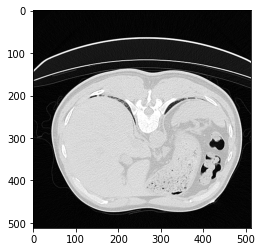

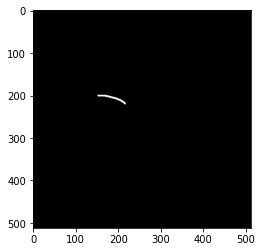

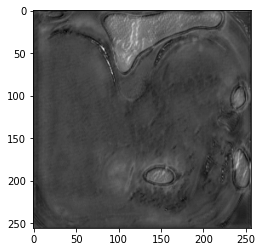

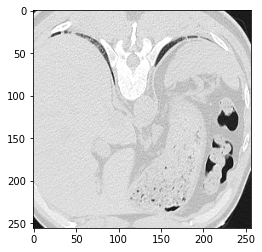

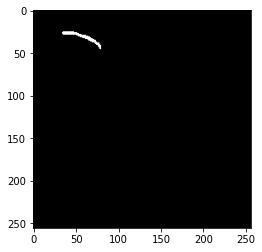

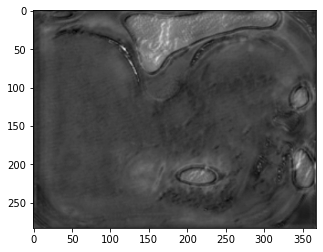

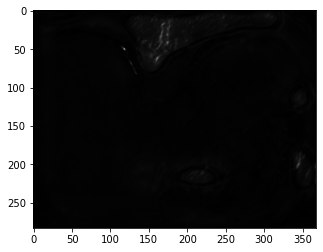

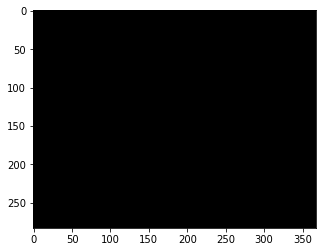

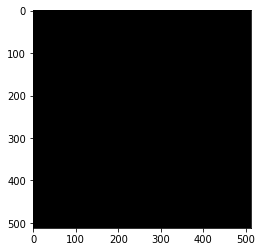

 Dice: 0.0 | IoU: 0.0 | Sen: 0.0 | Prec: 0.0 | Spec: 0.9988441467285156 | HD: 0.0 | HD95: 0.0 | F1: 0.0 


In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
metric = test_paper_single(model1, "/zhangtong/dealed_dataset/paper_m_20cases_test.json", device,"Covid19PaperTestDataset", 1, 215)

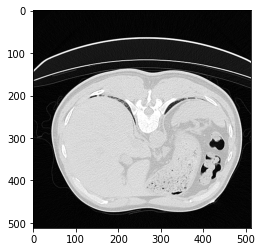

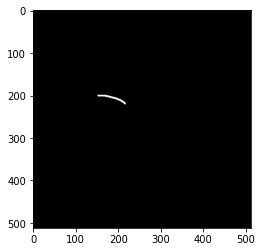

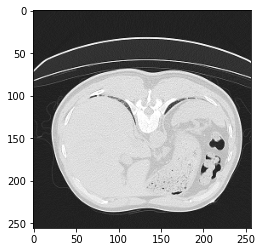

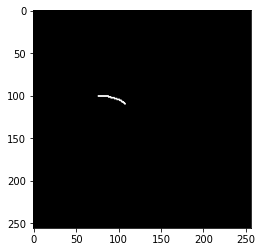

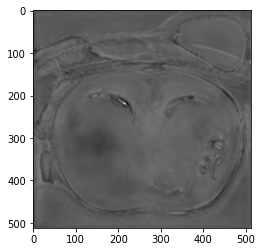

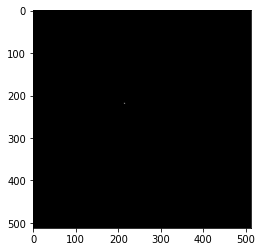

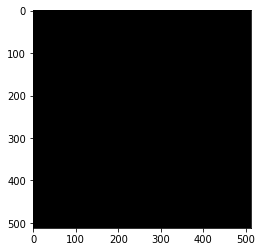

 Dice: 0.0 | IoU: 0.0 | Sen: 0.0 | Prec: 0.0 | Spec: 0.9988441467285156 | HD: 0.0 | HD95: 0.0 | F1: 0.0 


In [27]:
metric = test_paper_org_single(model2, "/zhangtong/dealed_dataset/paper_m_20_org_test.json", device,"Covid19PaperOrgTestDataset", 1, 215)

In [9]:
print_metric(metric)

' Dice: 0.7085917566013629 | IoU: 0.5742621999154826 | Sen: 0.8534038471321995 | Prec: 0.643064802056234 | Spec: 0.9911315138517472 | HD: 80.85147331631713 | HD95: 24.510529205379527 | F1: 0.9038970114517123 '

In [13]:
print_metric(metric)

' Dice: 0.6635084240175461 | IoU: 0.528417073531946 | Sen: 0.86689082946383 | Prec: 0.5734732926970989 | Spec: 0.9904785750353546 | HD: 57.90313453292747 | HD95: 27.61204859946731 | F1: 0.909284090851186 '

In [16]:
# UNet++
print_metric(metric)

' Dice: 0.5680142690532013 | IoU: 0.4416510210392559 | Sen: 0.8140078949580347 | Prec: 0.4898957333176505 | Spec: 0.9901740917774802 | HD: 65.23922651392304 | HD95: 31.542380922366274 | F1: 0.8705676016929362 '

In [20]:
print_metric(metric)

' Dice: 0.6860289799286108 | IoU: 0.5530709020406668 | Sen: 0.8336875623220937 | Prec: 0.619623569566015 | Spec: 0.9912101995592704 | HD: 75.48752440150254 | HD95: 26.227619242545845 | F1: 0.8883659496991406 '

In [7]:
import json
with open("/zhangtong/dealed_dataset/lung_seg_test.json", 'r', encoding='utf-8') as f:
    test_data_list = json.load(f)

In [9]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(display_list[i], cmap='gray')
        plt.axis('off')
    plt.show()

In [10]:
def plot_test_result(test_data_path:str, dataset_cls:str, idx:int, model):
    dataset_cls = dataset_factory(dataset_cls)
    test_data = dataset_cls(test_data_path, None, None, is_file=True)
    image, mask = test_data[idx]
    image = torch.unsqueeze(image, dim=0)
    pred_mask = model(image.cuda())
    pred_mask = torch.sigmoid(pred_mask)
    pred_mask = torch.where(pred_mask >= 0.5, torch.ones_like(pred_mask), torch.zeros_like(pred_mask))
    pred_mask = pred_mask.squeeze()
    pred_mask = pred_mask.unsqueeze(dim=-1)
    pred_mask = pred_mask.detach().cpu().numpy()
    image = image.squeeze()
    image = image.unsqueeze(dim=-1).numpy()*255
    mask = mask.squeeze()
    mask = mask.unsqueeze(dim=-1).numpy()
    display([image, mask, pred_mask])
    

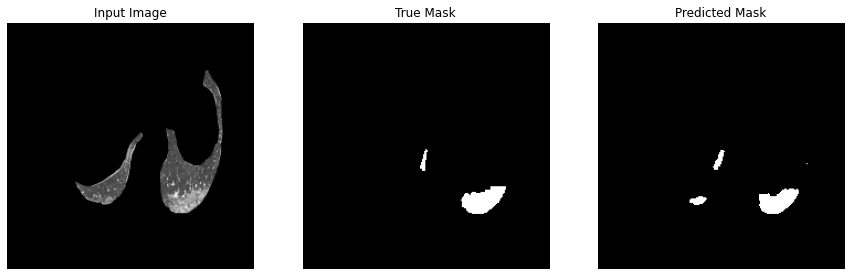

In [11]:
plot_test_result("/zhangtong/dealed_dataset/covid_seg_20_cases_m_test.json", "Covid19SegDataset", 10, model)